In [1]:
# Modules to import: 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import model_selection 
from sklearn import linear_model
import math 


In [2]:
# import the raw housing data set 
house_dat = pd.read_csv('https://raw.githubusercontent.com/krispad/Machine_Learning/master/housescal.txt', sep = ' ') 


In [3]:
# Apply function 'col_alt' to  'house_dat'  

#'col_alt' introduces features into the data and creates a modelling data set; e.g., modifies the dataset 'house_dat'(inplace ) 

def col_alt(dat, cols, adj_cols):
    ''' Arguments -
        dat: data
        cols: a list of cols to be adjusted to form new columns, e.g. for the dataset 'house_dat', cols = ['total_rooms', 'total_bedrooms', 'population']
        adj_cols: list of columns used to adjust 'cols', e.g., adj_cols= ['households']                                                                                               
    '''
    for name in cols: 
         # adjustments 
         a = dat[name]/dat[adj_cols[0]]
         dat.insert(value = a, column = 'avg_{}'.format(name), loc = dat.shape[1])
         dat.drop(labels = name, axis = 1, inplace = True)
    # Create a new feature (col)      
    b = [math.log(x) for x in dat[adj_cols[0]]]
    dat.insert(value = b , column = 'log_households', loc = dat.shape[1]) # log of the number of 'households' with the same 'house_value' in the lat/long region. 
    dat.drop(labels = 'households', axis = 1, inplace = True)

    return(dat)

# Application of the function col_alts to the dataset house_dat -- results in  'in place' changes to house_dat
col_alt(dat = house_dat, cols = ['total_rooms', 'total_bedrooms', 'population'], adj_cols = ['households']) 

,house_value,median_income,housing_median_age,latitude,longitude,avg_total_rooms,avg_total_bedrooms,avg_population,log_households
0,452600.0,8.3252,41,37.88,-122.23,6.984127,1.023810,2.555556,4.836282
1,358500.0,8.3014,21,37.86,-122.22,6.238137,0.971880,2.109842,7.037028
2,352100.0,7.2574,52,37.85,-122.24,8.288136,1.073446,2.802260,5.176150
3,341300.0,5.6431,52,37.85,-122.25,5.817352,1.073059,2.547945,5.389072
4,342200.0,3.8462,52,37.85,-122.25,6.281853,1.081081,2.181467,5.556828
...,...,...,...,...,...,...,...,...,...
20635,78100.0,1.5603,25,39.48,-121.09,5.045455,1.133333,2.560606,5.799093
20636,77100.0,2.5568,18,39.49,-121.21,6.114035,1.315789,3.122807,4.736198
20637,92300.0,1.7000,17,39.43,-121.22,5.205543,1.120092,2.325635,6.070738
20638,84700.0,1.8672,18,39.43,-121.32,5.329513,1.171920,2.123209,5.855072


We intrepret 'households' as a household of a family (families). 
The population counts appear to be based on the individuals living within a designated lat/long designation. 
Households with an average population of greater than 12 are deemed 'unusual' -- the associated households could be retirement centers, the extra population 'homeless' or living in tent cities, etc.

#### Questions one may ask of the data:
- Does 'households' include a count of caravans in trailer parks ?

- Does 'total_rooms', 'total_bedrooms' include a count of the rooms in hotels, motels or inns ?

In [4]:
# Introducing 'NaN' values
# We define a household as a dwelling with no more than 12 people
'''
Insert 'NaN's where the calculated average population per household is greater than 12;  when  'avg_total_rooms' 
> 15 and when 'avg_total_bedrooms' > 8
'''

ind = house_dat['avg_population'] > 12
house_dat.loc[ind, 'avg_population'] = 'NaN'
ind = house_dat['avg_total_rooms'] > 15
house_dat.loc[ind, 'avg_total_rooms'] = 'NaN'
ind = house_dat['avg_total_bedrooms'] > 8
house_dat.loc[ind, 'avg_total_bedrooms'] = 'NaN'
house_dat.info() # check 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   house_value         20640 non-null  float64
 1   median_income       20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   latitude            20640 non-null  float64
 4   longitude           20640 non-null  float64
 5   avg_total_rooms     20640 non-null  object 
 6   avg_total_bedrooms  20640 non-null  object 
 7   avg_population      20640 non-null  object 
 8   log_households      20640 non-null  float64
dtypes: float64(5), int64(1), object(3)
memory usage: 1.4+ MB


In [5]:
#Identifying the entries equal to 'NaN' in the house_dat dataset. 
na_ind = house_dat.iloc[:, :] == 'NaN'

# The number of 'NA' entries for each column is listed below
na_ind.sum(axis = 0)

# Note : house_dat has 'NaN' entries for the variables 'avg_population', 'avg_total_rooms', 'avg_total_bedrooms'


#####                Imputation of values marked as 'NaN' in 'house_dat'
    
X_house = pd.DataFrame(house_dat[['longitude', 'latitude', 'log_households', 'avg_total_rooms', 'avg_total_bedrooms', 'avg_population', 
                                        'median_income', 'housing_median_age']])
y_house = pd.Series(house_dat['house_value']) # has no missing values

X_na_ind = X_house.iloc[:, :] == 'NaN'

##### Imputation 
# transforming 'NaN' values to nan values as required by the imputation algorithms on sklearn.
X_house[X_na_ind] = np.nan  

# Impute the data using the nearest neighbour imputer in sklearn
# We need only apply the imputer to X_house (since y_house has no 'NaN' entries)

from sklearn.impute import KNNImputer 
imputer = KNNImputer(n_neighbors = 2)
X_house_imputed = pd.DataFrame(data = imputer.fit_transform(X_house), columns = imputer.feature_names_in_)


X_house.info() # check


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   log_households      20640 non-null  float64
 3   avg_total_rooms     20531 non-null  object 
 4   avg_total_bedrooms  20624 non-null  object 
 5   avg_population      20608 non-null  object 
 6   median_income       20640 non-null  float64
 7   housing_median_age  20640 non-null  int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 1.3+ MB


Modelling the California Housing Data 

- Comparing Bagging and Random Forests 


In [6]:
# Creating a Training/Test set 


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_house_imputed, y_house, train_size = .80) # Creating train/test pairs


In [7]:

#### Cost-Complexity Pruning is used to determine a parameter to use in Pruning a Tree
####### We demonstrate the construction of a sequence of alphas that is used to determine the optimal tree for each alpha
   ################################ Cost Complexity Pruning ############################

from sklearn import tree
dtr = tree.DecisionTreeRegressor()  
dtr.fit(X_train, y_train)
path = dtr.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path['ccp_alphas'], path['impurities']

###### The following piece of code takes a long time to compute (using the California housing value training data set ) 
###############   ------ we therefore restrict the ccp_alphas to ccp_alphas <= .5 
dtrs = []
for ccp_alpha in ccp_alphas[(ccp_alphas <= .5)]:
    dtr = tree.DecisionTreeRegressor(ccp_alpha=ccp_alpha)
    dtr.fit(X_train, y_train)
    dtrs.append(dtr)


depth = [dtr.tree_.max_depth for dtr in dtrs]
depth[:5] 
# The depth of the optimal tree as a function of alpha does not change for the first 5 values; in fact the depth remains
# unchanged for ccp_alphas <= 1


[33, 33, 33, 33, 33]

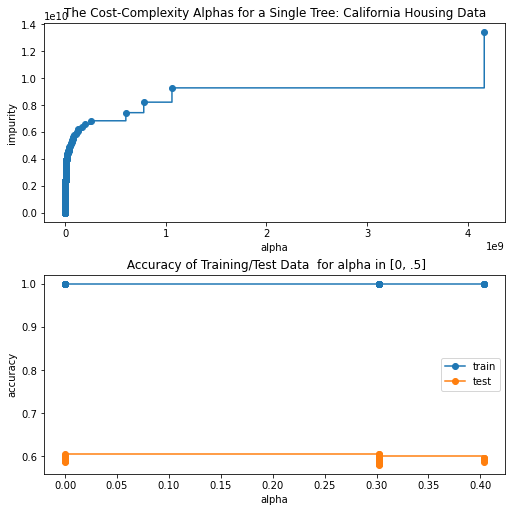

In [9]:
''' A visualization of the ccp_alphas ( alphas) sequence and the impact of the ccp_alphas < .5 on both the training 
and test sets '''

train_scores = [dtr.fit(X_train, y_train).score(X_train, y_train) for dtr in dtrs]
test_scores = [dtr.fit(X_train, y_train).score(X_test, y_test) for dtr in dtrs]

fig , ax = plt.subplots(2,1, figsize = (7, 7), constrained_layout = True)
ax[0].plot(ccp_alphas,impurities , marker = 'o', drawstyle = 'steps-post')
ax[0].set_title("The Cost-Complexity Alphas for a Single Tree: California Housing Data")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("impurity")
ax[1].set_title(" Accuracy of Training/Test Data  for alpha in [0, .5]")
ax[1].plot(ccp_alphas[ccp_alphas <= .5000], train_scores, marker = 'o', drawstyle = 'steps-post', label = 'train')
ax[1].plot(ccp_alphas[ccp_alphas <= .5000], test_scores, marker = 'o', drawstyle = 'steps-post', label = 'test')
ax[1].set_xlabel('alpha')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [10]:
from sklearn.ensemble import RandomForestRegressor

# Illustrating the difference in results between 'bagging' and 'random forests' for the California Housing Data 



# Absolute error --- bagging vs. random forests
def error_house(X_train, y_train, X_test, y_test, alpha, rnge, m):
    '''
     Parameters
     ----------
     alpha = ccp_alpha value --- the alpha multipller 
     rnge = the range if values (number of trees) in the forest
     m = number of trees added to the forest
    '''

    rf_train = []
    rf_test = []
    bg_train = []
    bg_test = []
   
    for n in range(1, rnge,m): # range of number of trees
        
        rf_house = RandomForestRegressor(max_samples = .8, max_features = .5, n_estimators = n,ccp_alpha= alpha)
        bg_house = RandomForestRegressor(max_samples = .8, max_features = 1, n_estimators = n, ccp_alpha = alpha)
        rf_house.fit(X_train, y_train)
        bg_house.fit(X_train, y_train)
        #regr_house.get_params()
        #regr_house.score(X = X_house_imputed, y =  y_house)
        #regr_house.apply(X = X_house_imputed)
        #regr_house.decision_path(X_house_imputed)
        rf_train.append(round(np.array([abs(y - x)/y for (y, x) in zip(y_train , rf_house.predict(X_train))]).mean(), 2))
        rf_test.append(round(np.array([abs(y - x)/y for (y, x) in zip(y_test , rf_house.predict(X_test))]).mean(),2))
        bg_train.append(round(np.array([abs(y - x)/y for (y, x) in zip(y_train , bg_house.predict(X_train))]).mean(), 2))
        bg_test.append(round(np.array([abs(y - x)/y for (y, x) in zip(y_test , bg_house.predict(X_test))]).mean(),2))
   
    fig, ax = plt.subplots(figsize = (7, 7))
    ax.plot(range(1,rnge, m), rf_train, color = 'black', label = 'random forest train')
    ax.plot( range(1,rnge, m), rf_test, color = 'red', label = 'random forest test')
    ax.plot( range(1, rnge, m), bg_train, color = 'green', label = 'bagging train')
    ax.plot(range(1,rnge, m), bg_test, color = 'orange', label = 'bagging test')
    ax.set_title('Bagging and Random Forests: California 1990 Housing Data')
    ax.set_xlabel("Number of Trees")
    ax.set_ylabel("Absolute error")
    ax.legend()
    plt.show()
    
  # For the visualization we use an alpha value(ccp_alpha) of zero (0) 
  # A forest of 40-60 trees is adequate for the illustration 

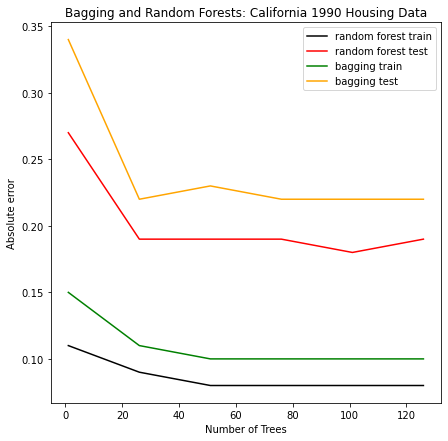

In [11]:
''' Illustration of the differences between 'bagging' and 'random forests' over a sequence of forest sizes
'''
error_house(X_train = X_train, y_train= y_train, X_test= X_test, y_test= y_test, alpha = 0 , rnge= 151, m = 25)
    

Text(0.5, 1.0, 'Random Forest Model : Feature Importance for the California Housing Data ')

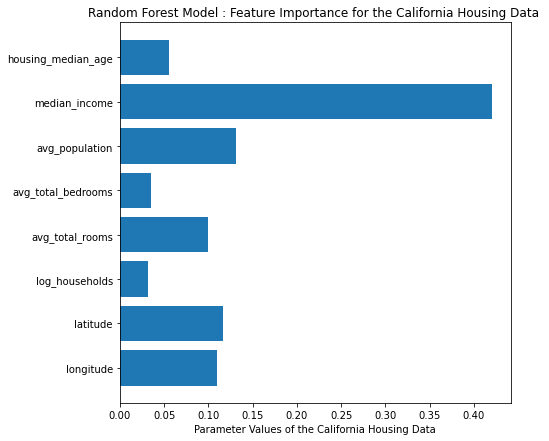

In [13]:
# Variable Importance in the California Housing Data
rf_house = RandomForestRegressor(max_samples = .8, max_features = .5, n_estimators = 50,ccp_alpha= 0)
rf_house.fit(X_train, y_train)
Cal_RF_Param = pd.DataFrame({'Variable_Names': X_train.columns, 'Param_Values': rf_house.feature_importances_})

fig, ax = plt.subplots(figsize = (7, 7))
ax.barh(Cal_RF_Param['Variable_Names'] , Cal_RF_Param['Param_Values'])
ax.set_xlabel('Parameter Values of the California Housing Data')
ax.set_title('Random Forest Model : Feature Importance for the California Housing Data ')





Commentary on the Features in the California Housing Data 
- Not suprisingly the 'median_inc' variable is important
- 'median_inc' is followed by 'avg_population', 'longitude' and 'latitude' 

A comparison amongst 'ensemble' methods

- AdaBoost, Gradient Boosting and Random Forests are compared
  - The number of estimators ( trees) is the same for each method
  - The loss function for the Gradient Boosting Method and the splitting criterion for Random Forests is 'absolute error'
  - The alpha used for pruning the trees in Random Forests and Gradient Boosting is set to zero



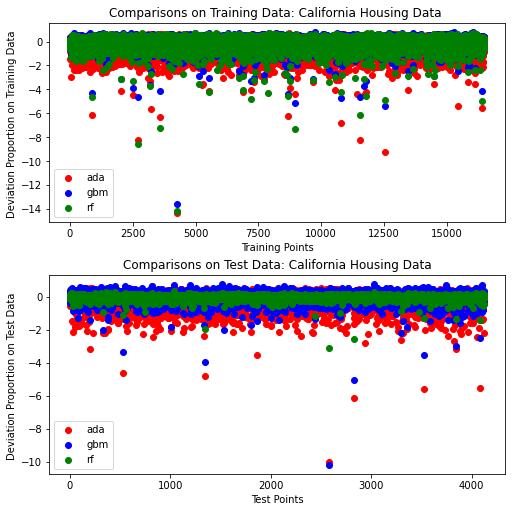

In [12]:
######################## Differences between GBM, Random Forests and AdaBoost ##################################
    
from sklearn.ensemble import AdaBoostRegressor , GradientBoostingRegressor , RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
    
ada = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = 3), n_estimators = 45, learning_rate = .1, loss = 'linear')
gbm = GradientBoostingRegressor(loss = "absolute_error", n_estimators = 45) # learning _rate = .1, ccp_alpha = 0) 
rf = RandomForestRegressor(n_estimators = 45, criterion = 'absolute_error', ccp_alpha = 0, max_features = .5)
    
clf = [ada, gbm, rf]
pred_rslts_train = []
pred_rslts_test = []
for k in clf:
    k_train = k.fit(X_train, y_train)
    k_test = k.fit(X_test, y_test)
        
    k_pred_train = [round((y - round(x, 2))/y, 2) for (x, y) in zip(list(k_train.predict(X_train)), list(y_train))]
    k_pred_test =  [round((y - round(x, 2))/y, 2) for (x, y) in zip(list(k_test.predict(X_test)), list(y_test))]
    pred_rslts_test.append(k_pred_test)
    pred_rslts_train.append(k_pred_train)
    
#pred_rslts.append(list(y_test))
col = ['red', 'blue', 'green']
tech = ['ada', 'gbm', 'rf']
import matplotlib.pyplot as plt 
    
fig, ax = plt.subplots(figsize = (7,7), constrained_layout = True, nrows = 2, ncols = 1)
for i in range(0, 3):
    ax[0].scatter(range(0, len(y_train)), pred_rslts_train[i], color = col[i], label = tech[i])
        
    ax[1].scatter(range(0, len(y_test)), pred_rslts_test[i], color = col[i], label = tech[i])
ax[0].set_title("Comparisons on Training Data: California Housing Data ")    
ax[1].set_title("Comparisons on Test Data: California Housing Data")
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel("Training Points")
ax[1].set_xlabel("Test Points")
ax[0].set_ylabel("Deviation Proportion on Training Data ")
ax[1].set_ylabel("Deviation Proportion on Test Data ")
plt.show()

Comments on the 'ensemble' methods used:
- On the Test set, the Random Forest method clearly does better than both the AdaBoost and Gradient Boosting Method.
- It is not entirely clear that the Random Forest method has a smaller range of deviations from the oberved Training responses than the Gradient Boosting or AdaBoost method.